# EOF Analysis of AR days

* Multivariate EOF analysis of H, U and V at 250 hPa in Extratropics and Q, U, and V at 850 hPa in Tropics

In [1]:
# Import Python modules
import os, sys
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from sklearn.cluster import KMeans
from itertools import cycle
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence
from eofs import *
from ar_funcs import preprocess_ar_area_subregions
from kmeans import *

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/cEOF_tropics_extratropics/'      # figures


In [3]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)

rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'

## Data

### AR time series

In [4]:
## Select MERRA2 or ERA5
reanalysis = 'era5'

if reanalysis == 'era5':
    start_date = '1979-01-01'
    end_date = '2018-12-31'
    filename = 'ar_catalog_ERAI_fraction_HASIAsubregions.nc'
## if MERRA2
else:
    start_date = '1980-01-01'
    end_date = '2017-12-31'
    filename = 'ar_catalog_fraction_HASIAsubregions.nc'
    
f1 = path_to_data + 'CH1_generated_data/' + filename
ds = xr.open_dataset(f1)
# Set dates
ds = ds.sel(time=slice(start_date, end_date))
## Preprocess AR subregions - get dataframe of AR days based on area threshold
df = preprocess_ar_area_subregions(df=ds.to_dataframe(), thres=0.3)
# Show table
df.head()

,R01,R02,R03,ar,location
time,,,,,
1979-01-01,0.000000,0.0,0.0,0,NaN
1979-01-02,0.000000,0.0,0.0,0,NaN
1979-01-03,0.005102,0.0,0.0,0,NaN
1979-01-04,0.000000,0.0,0.0,0,NaN
1979-01-05,0.000000,0.0,0.0,0,NaN


### Import reanalysis

#### ERA5

In [5]:
## Set variable names (for saving data/figs)
var_names = 'HUV250QUV850'
eofmode = 't' # s or t
dispmat = 'cor' # dispersion matrix type correlation/covariance

# Select lat/lon grid 
# Tropics/Extratropics Domain
lonmin = 0
lonmax = 120
latmin = -15
latmax = 65

lev = [850., 250.]

# for figure names for testing different configurations
fname_id = var_names + eofmode + str(lonmin) + str(lonmax) + str(latmin) + str(latmax) + dispmat

def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=lev)

# open HUV anomaly data
filepath_pattern = path_to_data + 'ERA5/huvq/anomalies/daily_filtered_anomalies_huvq_*.nc'
    
    
f2 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')



In [6]:
# Create new dataset to rename lat lon
ds = xr.Dataset({'H': (['time', 'level', 'lat', 'lon'], f2['z'].values),
                 'U': (['time', 'level',  'lat', 'lon'], f2['u'].values),
                 'V': (['time', 'level',  'lat', 'lon'], f2['v'].values),
                 'QV': (['time', 'level',  'lat', 'lon'], f2['q'].values)},
                      coords={'time': (['time'], f2.time.values),
                              'level': (['level'], f2.level.values),
                              'lat': (['lat'], f2.latitude.values),
                              'lon': (['lon'], f2.longitude.values)})

ds
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))

ds size in GB 36.28



In [ ]:
# ## Set variable names (for saving data/figs)
# var_names = 'HUVQ500'
# eofmode = 't' # s or t
# dispmat = 'cor' # dispersion matrix type correlation/covariance

# ## Select lat/lon grid 
# # Tropics/Extratropics Domain
# lonmin = 0
# lonmax = 120
# latmin = -15
# latmax = 65

# # for figure names for testing different configurations
# fname_id = var_names + eofmode + str(lonmin) + str(lonmax) + str(latmin) + str(latmax) + dispmat

# ### MERRA2 DATA ###
# def preprocess(ds):
#     '''keep only selected lats and lons'''
#     return ds.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))

# # open H data
# filepath_pattern = path_to_data + 'MERRA2/anomalies/H500/daily_*.nc'

# ds_h = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, concat_dim='time', combine='by_coords')
# print('ds size in GB {:0.2f}\n'.format(ds_h.nbytes / 1e9))

# # open QV data
# filepath_pattern = path_to_data + 'MERRA2/anomalies/QV500/daily_*.nc'

# ds_q = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, concat_dim='time', combine='by_coords')
# print('ds size in GB {:0.2f}\n'.format(ds_q.nbytes / 1e9))

# ## open UV data
# filepath_pattern = path_to_data + 'MERRA2/anomalies/UV500/daily_*.nc'
# ds_uv = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')
# print('ds size in GB {:0.2f}\n'.format(ds_uv.nbytes / 1e9))

# ## combine H and UV data into 1 ds object
# ds = xr.merge([ds_h, ds_uv.U, ds_uv.V, ds_q])
# # ds

In [7]:
# Add AR time series to merra; set as coordinate variables
ds['ar'] = ('time', df.ar)
ds = ds.set_coords('ar')

ds['location'] = ('time', df.location)
ds = ds.set_coords('location')

# print dataset
print(ds)

<xarray.Dataset>
Dimensions:   (lat: 161, level: 2, lon: 241, time: 14610)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01T09:00:00 ... 2018-12-31T09:00:00
  * level     (level) float64 850.0 250.0
  * lat       (lat) float32 65.0 64.5 64.0 63.5 63.0 ... -13.5 -14.0 -14.5 -15.0
  * lon       (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.5 119.0 119.5 120.0
    ar        (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    location  (time) object nan nan nan nan nan nan ... nan nan nan nan nan nan
Data variables:
    H         (time, level, lat, lon) float64 931.6 945.5 956.6 ... 421.8 425.2
    U         (time, level, lat, lon) float64 -8.089 -7.954 ... -10.98 -11.09
    V         (time, level, lat, lon) float64 6.575 6.285 ... -1.857 -1.946
    QV        (time, level, lat, lon) float64 -0.001679 -0.001712 ... 0.0001567


### Data Subset Selection

In [8]:
# Trim date range
if reanalysis == 'era5':
    start_date = '1979-12-01'
    end_date = '2018-02-28'
    ys = 1979
    ye = 2018
else:
    start_date = '1980-12-01'
    end_date = '2017-02-28'
    ys = 1980
    ye = 2017
    
idx = slice(start_date, end_date)
ds = ds.sel(time=idx)

# Select DJF months
idx = (ds.time.dt.month >= 12) | (ds.time.dt.month <= 2)
ds = ds.sel(time=idx)

# # Select AR days JUST IN R01
# idx = (ds.ar >= 1) & (ds.location == 'R01')
# Select AR days in all subregions
idx = (ds.ar >= 1)
ds_ar = ds.sel(time=idx)

# print results
print(ds_ar)

<xarray.Dataset>
Dimensions:   (lat: 161, level: 2, lon: 241, time: 371)
Coordinates:
  * time      (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * level     (level) float64 850.0 250.0
  * lat       (lat) float32 65.0 64.5 64.0 63.5 63.0 ... -13.5 -14.0 -14.5 -15.0
  * lon       (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.5 119.0 119.5 120.0
    ar        (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    location  (time) object 'R03' 'R01' 'R01' 'R01' ... 'R03' 'R02' 'R01' 'R01'
Data variables:
    H         (time, level, lat, lon) float64 -1.101e+03 -1.094e+03 ... -98.64
    U         (time, level, lat, lon) float64 1.735 2.0 ... -0.2281 -0.9317
    V         (time, level, lat, lon) float64 1.768 1.552 1.373 ... -3.327 -3.39
    QV        (time, level, lat, lon) float64 0.0003972 0.0003931 ... -3.129e-05


In [9]:
# Count number of independent AR events

years = np.arange(ys, ye) 
nyrs = len(years)
total_events = 0
for k in range(nyrs-1):    
    # Extract single DJF season
    date1 = "{}-12-01".format(years[k])
    date2 = "{}-02-28".format(years[k+1])
    x = ds.ar.sel(time=slice(date1,date2)).values
    # Count AR events in that season
    tags, tmp = persistence(x)
    # Add to running event count
    total_events += tmp

print("Number of independent AR events: ", total_events)

Number of independent AR events:  199


## Preprocessing

### Reshape, center, and standardize data matrix

In [10]:
%%time
# Load merra_ar dataset into memory
ds_ar = ds_ar.load()


CPU times: user 20 µs, sys: 82 µs, total: 102 µs
Wall time: 115 µs


In [11]:
# "Tropics" Domain
tlonmin = 0
tlonmax = 120
tlatmin = -15
tlatmax =  25

# "Extratropics" Domain
etlonmin = 0
etlonmax = 120
etlatmin = 25
etlatmax =  65

## Create list of variable arrays
## FOR MERRA2 need to switch back to slice(latmin, latmax)
# Extratropic variables
var1 = ds_ar.U.sel(lon=slice(etlonmin, etlonmax), lat=slice(etlatmax, etlatmin), level=250.)
var2 = ds_ar.V.sel(lon=slice(etlonmin, etlonmax), lat=slice(etlatmax, etlatmin), level=250.)
var3 = ds_ar.H.sel(lon=slice(etlonmin, etlonmax), lat=slice(etlatmax, etlatmin), level=250.)

# Tropics variables
var4 = ds_ar.U.sel(lon=slice(tlonmin, tlonmax), lat=slice(tlatmax, tlatmin), level=850.)
var5 = ds_ar.V.sel(lon=slice(tlonmin, tlonmax), lat=slice(tlatmax, tlatmin), level=850.)
var6 = ds_ar.QV.sel(lon=slice(tlonmin, tlonmax), lat=slice(tlatmax, tlatmin), level=850.)

var_list = [var1, var2, var3, var4, var5, var6]

# Check that sizes of arrays match
for i, in_array in enumerate(var_list):
    # Extract variable as numpy array
    var1 = in_array.values
    print(var1.shape)


(371, 81, 241)
(371, 81, 241)
(371, 81, 241)
(371, 81, 241)
(371, 81, 241)
(371, 81, 241)


In [12]:
%%time
# Weight the data by the square root of the cosine of the lat
var_list = spatial_weights(var_list)

## Flatten data to [time x space]
var_list = flatten_array(var_list)

## Center data
var_list = center_data(var_list)

## Standardize Arrays by removing the mean and dividing by the standard deviation of the columns
## For multivariate, place into single flattened array
Xs = standardize_arrays(var_list, mode=eofmode, dispersion_matrix=dispmat)


EOF mode:  s
Dispersion Matrix:  cor
(371, 117126)
Column means:  0.0
Column std:  1.0
CPU times: user 2.6 s, sys: 1.43 s, total: 4.02 s
Wall time: 4.01 s


## EOF Analysis

In [13]:
%%time

# Compute eigenvalues & eigenvectors
R, evals, evecs = calc_eigs(z=Xs, mode=eofmode)

print('Eigenvalues: ', evals.shape)
print(evals, '\n')

print('Eigenvectors: ', evecs.shape)
print(np.round(evecs, 3), '\n')

Eigenvalues:  (371,)
[3.41261971e+01 2.30860026e+01 1.67008940e+01 1.59278721e+01
 1.40000185e+01 1.31798045e+01 1.15375430e+01 1.00010800e+01
 8.10206638e+00 7.87210747e+00 7.69158437e+00 7.06391518e+00
 6.90329536e+00 6.05279536e+00 5.55746390e+00 4.87949825e+00
 4.66432064e+00 4.44293422e+00 4.24334750e+00 4.16845460e+00
 4.08659225e+00 3.83249668e+00 3.64789541e+00 3.24607845e+00
 3.03779930e+00 2.93537568e+00 2.77127205e+00 2.69910419e+00
 2.63870467e+00 2.55264792e+00 2.50361871e+00 2.40896983e+00
 2.27303847e+00 2.26726871e+00 2.18996556e+00 2.12415949e+00
 2.06019611e+00 1.93009217e+00 1.84593733e+00 1.79112313e+00
 1.74518263e+00 1.72001275e+00 1.65815406e+00 1.63424940e+00
 1.58210909e+00 1.55069541e+00 1.55927908e+00 1.53612734e+00
 1.47384404e+00 1.45556971e+00 1.42148122e+00 1.39181746e+00
 1.32078777e+00 1.29820644e+00 1.27376425e+00 1.25022438e+00
 1.20847758e+00 1.18745830e+00 1.15880669e+00 1.13505967e+00
 1.11330817e+00 1.08958393e+00 1.07692734e+00 1.04706721e+00
 1.

Text(0.5, 1.0, 'Dispersion Matrix (cor)')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


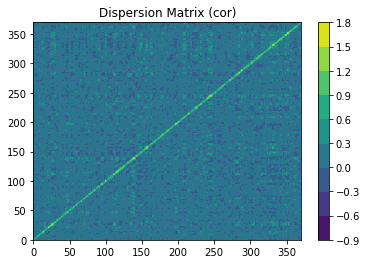

In [14]:
plt.contourf(R)
plt.colorbar()
title = 'Dispersion Matrix (' + dispmat + ')'
plt.title(title)

### Explained Variance

In [15]:
# Calculate the percent explained var by each eigenvector
pctvar = pct_variance(evals)

# Number of EOFs that explain more than 1% of the total variance
idx = pctvar[pctvar >= 1.0]
neofs = len(idx)

# print exp var >= 1.0
cumvar = np.sum(pctvar[0:neofs-1])
print(f'Cumulative variance explained by the first {neofs} EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var: neofs = 4
cumvar = np.sum(pctvar[0:3])
print(f'Cumulative variance explained by the first 4 EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var for 4 eofs
for k in range(4):
    print(f'{k+1} \t {pctvar[k]:.2f}%')

Cumulative variance explained by the first 22 EOFs:
57.76% 

Cumulative variance explained by the first 4 EOFs:
19.92% 

1 	 9.20%
2 	 6.22%
3 	 4.50%
4 	 4.29%


### North Test

In [16]:
err = north_test(evals, total_events)
upper = pctvar + err
lower = pctvar - err

print(np.round(upper[0:6],3))
print(np.round(pctvar[0:6],3))
print(np.round(lower[0:6],3))

[10.121  6.846  4.953  4.724  4.152  3.909]
[9.198 6.223 4.502 4.293 3.774 3.552]
[8.276 5.599 4.05  3.863 3.395 3.196]


### Fig 2: Variance

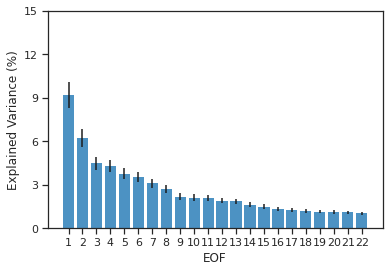

In [17]:
# set seaborn style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# create figure
fig, ax = plt.subplots(figsize=(6,4))

# plot data
xvals = np.arange(neofs) + 1
ax.bar(xvals, pctvar[0:neofs], yerr=err[0:neofs], 
       color='tab:blue', alpha=0.8)

# x-axis
ax.set_xlabel('EOF')
ax.set_xticks(xvals)

# y-axis
ax.set_ylabel('Explained Variance (%)')
yticks = np.arange(0,16,3)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks) 

# save fig
filepath = path_to_figs + 'exp_variance_' + fname_id + '.png'
plt.savefig(filepath, dpi=300)

# show
plt.show()

### Loadings

In [18]:
neofs = 19
loads = loadings(evals, evecs, neofs)

print(loads.shape)
print(np.round(loads,3))

(371, 19)
[[ 0.289  0.192 -0.125 ... -0.049 -0.055  0.237]
 [ 0.246 -0.095  0.026 ... -0.001  0.003  0.168]
 [ 0.17   0.097  0.241 ...  0.045  0.1    0.21 ]
 ...
 [-0.452 -0.154 -0.406 ...  0.068  0.129  0.035]
 [-0.197 -0.067 -0.076 ...  0.216 -0.014 -0.017]
 [-0.065 -0.191 -0.153 ... -0.057  0.178 -0.013]]


### Save EOFs

In [19]:
# Save eigenvalues, eigenvectors, and loadings

neofs = 4   # number of EOFs to save (evecs, loadings3)

outfile = path_to_out + 'eigenvalues_'+ fname_id + '.txt'
np.savetxt(outfile, evals, fmt='%.5f')

outfile = path_to_out + 'eigenvectors_'+ fname_id + '.txt'
np.savetxt(outfile, evecs[:,0:neofs], fmt='%.5f', delimiter=',')

outfile = path_to_out + 'loadings_'+ fname_id + '.txt'
np.savetxt(outfile, loads[:,0:neofs], fmt='%.4f', delimiter=',')


### PCs

In [20]:
# Calculate EOFS (spatial modes)
neofs = 19
pcs = calc_eofs(Xs, evecs, neofs, mode=eofmode)

In [21]:
# Split pcs into separate arrays for each variable
ntim, nlat, nlon = var2.shape
npts = nlat*nlon
nvar = len(var_list)
# Reshape spatial dim back to 2D map
pcmodes = var_list
for i in np.arange(len(var_list)):
    tmp = pcs[:,i*npts:(i+1)*npts]
    pcmodes[i] = np.reshape(tmp, (neofs,nlat,nlon))

### Fig 3: Spatial Modes

In [22]:
# Panel Plot of Spatial Modes

# number of eofs to plot
neofs = 4

# Data for plotting extratropics
lons_et = var2.lon.data
lats_et = var2.lat.data
udat_et = pcmodes[0][0:neofs,:,:]
vdat_et = pcmodes[1][0:neofs,:,:]
data_et = pcmodes[2][0:neofs,:,:]

# Data for plotting tropics
lons_t = var4.lon.data
lats_t = var4.lat.data
udat_t = pcmodes[3][0:neofs,:,:]
vdat_t = pcmodes[4][0:neofs,:,:]
data_t = pcmodes[5][0:neofs,:,:]

print(np.min(data_et), np.max(data_et))
print(np.min(data_t), np.max(data_t))

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subtitles
eof_label = [ ]
pc_label = [ ]
var_label = [ ]
for k in range(neofs):
    eof_label.append("EOF{:1d}".format(k+1,))
    pc_label.append("PC{:1d}".format(k+1,))
    var_label.append("{:.2f}%".format(pctvar[k]))

-14.53357905059975 13.781068061394674
-11.401938863675106 11.890115328041418


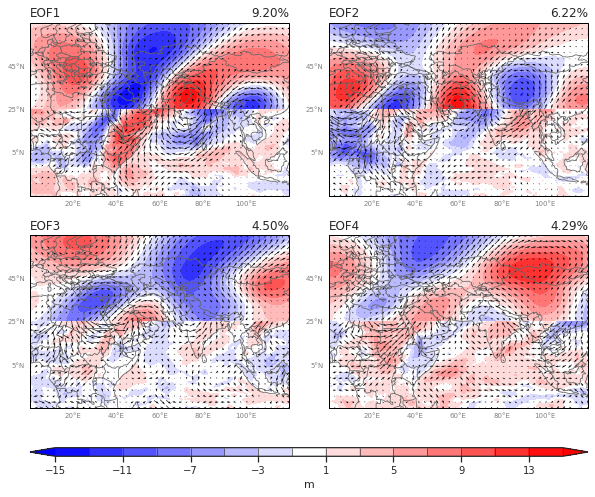

In [23]:
# Create figure
fig = plt.figure(figsize=(10,11))
filepath = path_to_figs + 'eofs_'+ fname_id + '.png'
nrows = 2
ncols = 2
# sns.set_style('ticks')

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 
                111, 
                axes_class=axes_class,
                nrows_ncols=(nrows, ncols), 
                axes_pad = 0.55,
                cbar_location='bottom', 
                cbar_mode='single',
                cbar_pad=0.0, 
                cbar_size='2.5%',
                label_mode='')

#newcmap = cmocean.tools.crop_by_percent(cmo.matter, 15, which='max', N=None)

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
#     ax = draw_basemap(ax, extent=None, xticks=dx, yticks=dy)
    
    # Add contour fill plot for extratropics
    clevs = np.arange(-15,16,2)
    cf = ax.contourf(lons_et, lats_et, data_et[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="bwr", extend='both')
    # add vectors for extratropics
    ax.quiver(lons_et, lats_et, udat_et[k,:,:], vdat_et[k,:,:], transform=datacrs,
              color='black', pivot='middle', regrid_shape=30) 
    
    # Add contour fill plot for q500
    cf = ax.contourf(lons_t, lats_t, data_t[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="bwr", extend='both')
    # add vectors for tropics
    ax.quiver(lons_t, lats_t, udat_t[k,:,:], vdat_t[k,:,:], transform=datacrs,
              color='black', pivot='middle', regrid_shape=30)
    
    # subtitles
    ax.set_title(eof_label[k], loc='left', fontsize=12)
    ax.set_title(var_label[k], loc='right', fontsize=12)
    
# single colorbar
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('m', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Display figure
plt.savefig(filepath, dpi=200, bbox_inches='tight')
plt.show()

/home/nash/DATA/repositories/AR_types/figs/cEOF_tropics_extratropics/pc_HUV250QUV850s0120-1565cor.png


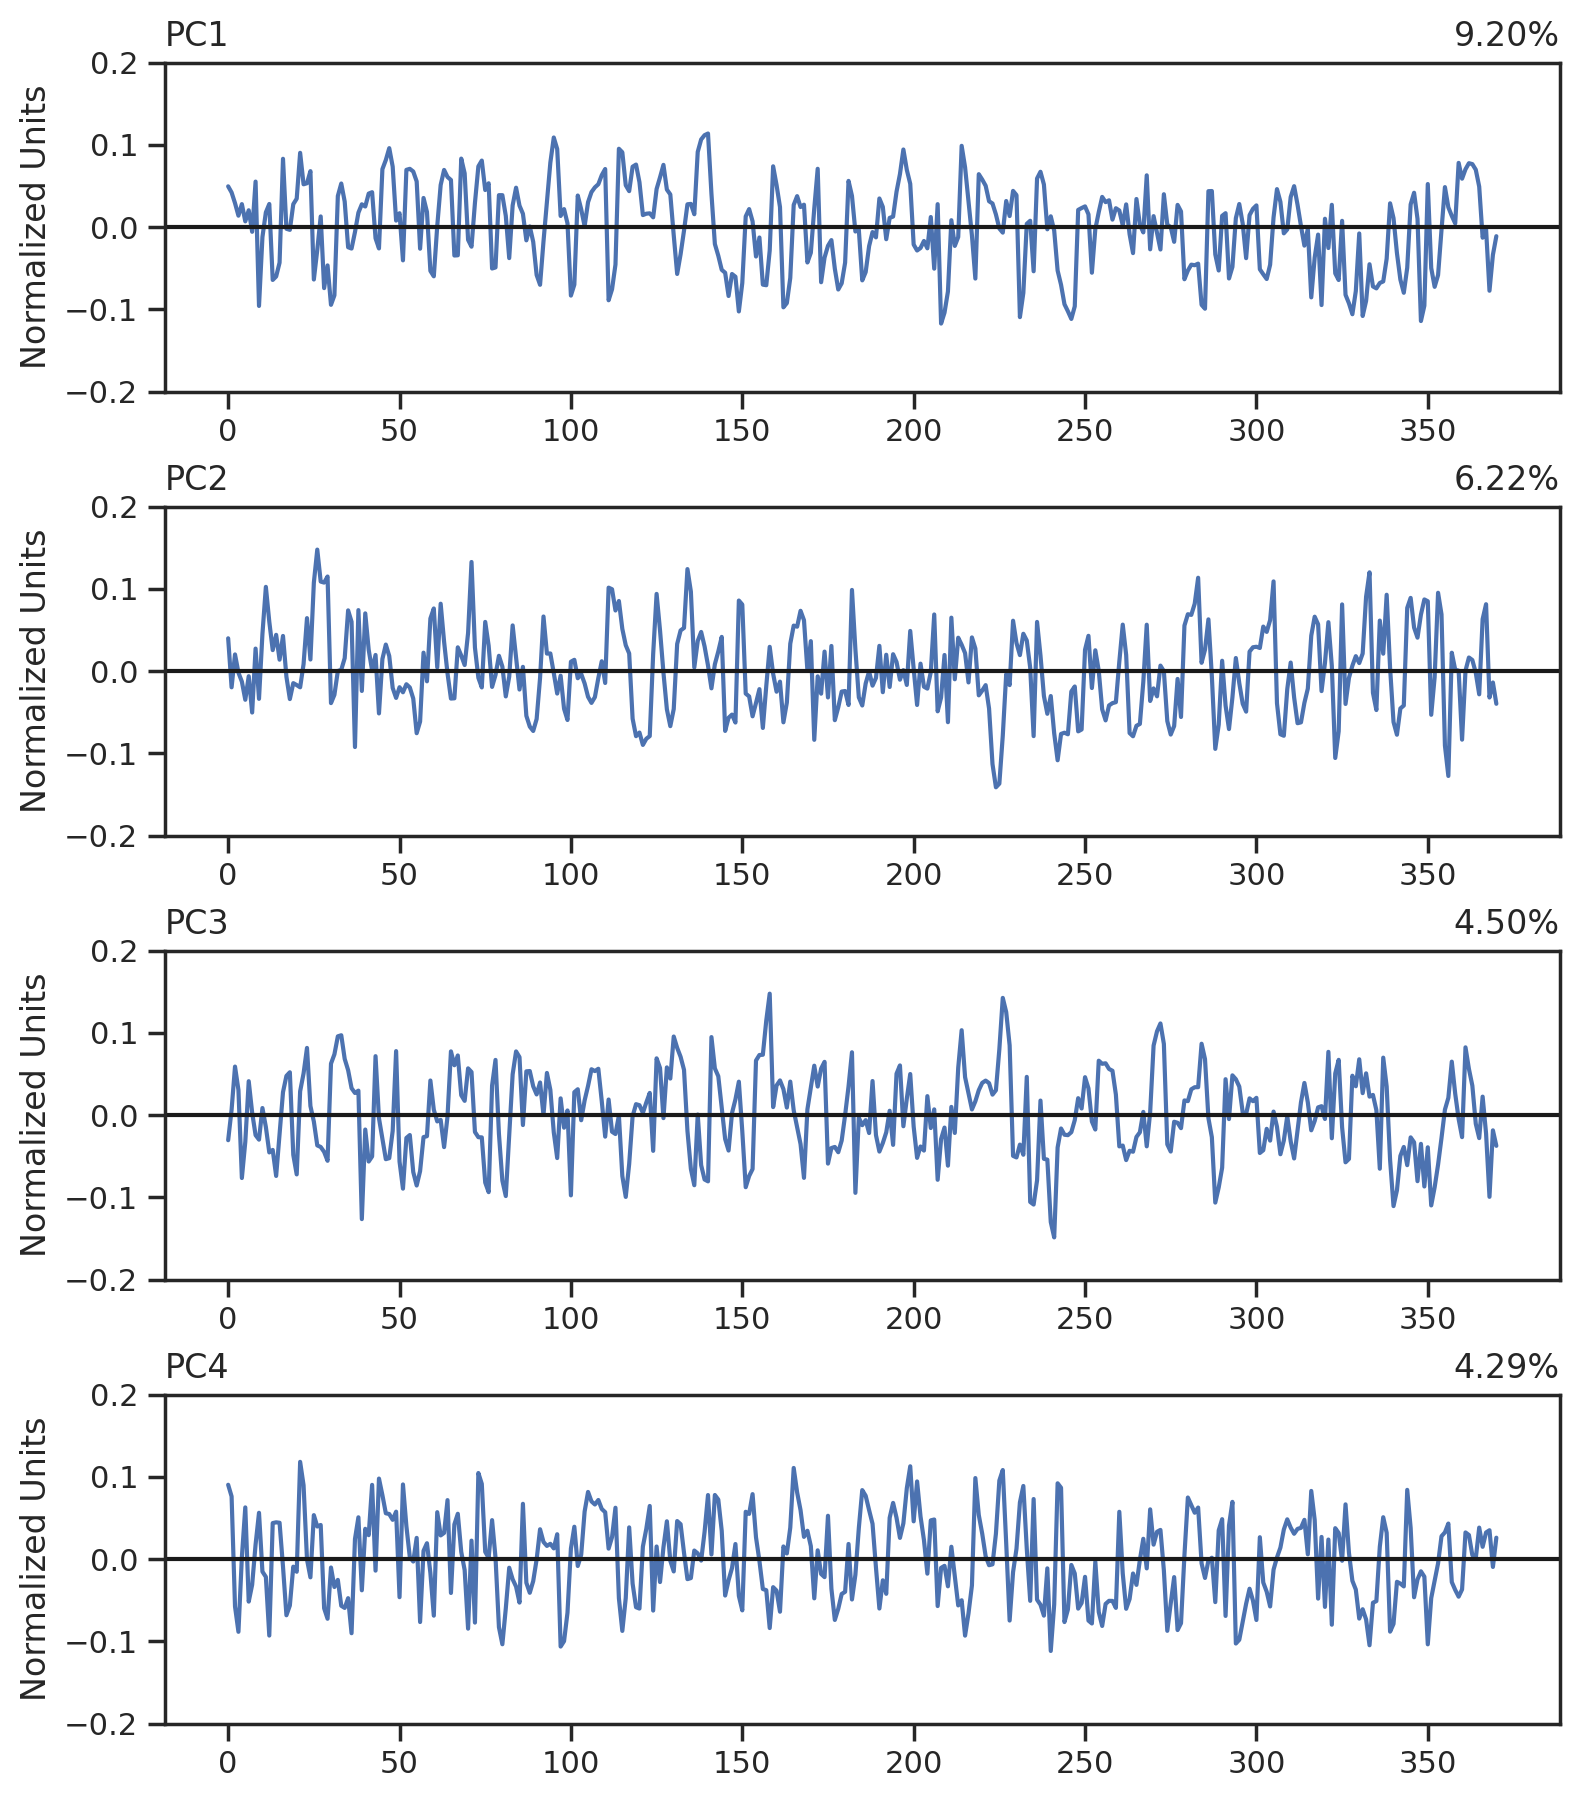

<Figure size 1800x2200 with 0 Axes>

In [24]:
fig = plt.figure(figsize=(9,11))
fig.dpi = 200
fname = path_to_figs + 'pc_'+ fname_id
fmt = 'png'
results = evecs[:,:4]

X, nplots = results.shape
x = np.arange(len(results))

for i in np.arange(nplots):
    ax = plt.subplot(4, 1, i+1)
    ax.plot(x, results[:,i], '-')
    ax.axhline(0, color='k')
    ax.set_ylim(-0.2, 0.2)
    ax.set_ylabel('Normalized Units')
    # subtitles
    ax.set_title(pc_label[i], loc='left', fontsize=12)
    ax.set_title(var_label[i], loc='right', fontsize=12)

plt.subplots_adjust(hspace=0.35, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

### EOF represented as correlation

In [49]:
def correlation_map(pcs, var_list, n=None):
    """Correlation maps for a set of PCs and a spatial-temporal field.
    Given an array where the columns are PCs and an array containing spatial-temporal
    data where the first dimension represents time, one correlation map
    per PC is computed.
    The field must have the same temporal dimension as the PCs. Any
    number of spatial dimensions (including zero) are allowed in the
    field and there can be any number of PCs.
    **Arguments:**
    *pcs*
        PCs as the columns of an array.
    *var_list*
        list of Spatial-temporal fields with time as the first dimension.
    
    **Returns:**
    *correlation_maps*
        An array with the correlation maps reshaped to the data array size.

    """
    ntime, neofs = pcs.shape
    ntim, nlat, nlon = var_list[0].shape
    if n is None:
        n=ntim
    ## Flatten data to [time x space]
    flat_var = flatten_array(var_list)
    
    field = flat_var[0]
    # remove the mean along the leading dimension.
    pcs_cent = pcs - pcs.mean(axis=0)
    field_cent = field - field.mean(axis=0)

    # Compute the standard deviation of the PCs and the fields along the time
    # dimension (the leading dimension).
    pcs_std = pcs_cent.std(axis=0)
    field_std = field_cent.std(axis=0)
    # Set the divisor.
    div = np.float64(pcs_cent.shape[0])
    # Compute the correlation map.
    cor = ma.dot(field_cent.T, pcs_cent).T / div
    cor = ma.masked_invalid(cor)
    # divide by std dev of pc * std dev of field
    cor /= ma.outer(pcs_std, field_std)
    
    # Reshape correlation results
    # Reshape spatial dim back to 2D map
    cormap = np.reshape(cor, (neofs,nlat,nlon))
    # Compute P-value
    #Compute t-statistics
    tstats = cormap*np.sqrt(n-2)/np.sqrt(1-cormap**2)
    
    pval   = t.sf(tstats, n-2)*2
    
    return cormap, pval

In [50]:
cormaph250, pvalh250 = correlation_map(evecs[:,0:2], [ds_ar.H.sel(level=250.)], n=total_events)
cormapq250, pvalq250 = correlation_map(evecs[:,0:2], [ds_ar.QV.sel(level=250.)], n=total_events)
cormapv250, pvalv250 = correlation_map(evecs[:,0:2], [ds_ar.V.sel(level=250.)], n=total_events)
cormapu250, pvalu250 = correlation_map(evecs[:,0:2], [ds_ar.U.sel(level=250.)], n=total_events)

cormaph850, pvalh850 = correlation_map(evecs[:,0:2], [ds_ar.H.sel(level=850.)], n=total_events)
cormapq850, pvalq850 = correlation_map(evecs[:,0:2], [ds_ar.QV.sel(level=850.)], n=total_events)
cormapv850, pvalv850 = correlation_map(evecs[:,0:2], [ds_ar.V.sel(level=850.)], n=total_events)
cormapu850, pvalu850 = correlation_map(evecs[:,0:2], [ds_ar.U.sel(level=850.)], n=total_events)

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


In [36]:
from scipy.stats import t

def lag_linregress_3D(x, y, lagx=0, lagy=0, n=None):
    """
    Adapted from https://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    **Arguments:**
    *x*
        PCs as the columns of an array.
    *y*
        xarray Dataset with variables to correlate
    *lagx*
        the specified lag amount to shift the x
    *lagy*
        the specified lag amount to shift the y
    *n*
        The number of events used for determining degrees of freedom (n-2). 
        if no input, n will be set to the length of x
    
    **Returns**
    Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.   
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    if n is None:
        n=x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    tstats = tstats.to_array()
    stderr = slope/tstats
    
    pval   = t.sf(tstats, n-2)*2

    return cov,cor,slope,intercept,pval,stderr

In [28]:
# put PCS into dataset object
npcs = 2
ds_pc = xr.Dataset({'pc': (['time', 'pcs'], evecs[:,0:npcs])},
                      coords={'time': (['time'], ds_ar.time.values),
                              'pcs': (['pcs'], np.arange(npcs))})
ds_pc.pc.sel(pcs=0)

<xarray.DataArray 'pc' (time: 371)>
array([ 4.95500793e-02,  4.21072562e-02,  2.91146420e-02,  1.38322606e-02,
        2.79241171e-02,  6.90086216e-03,  2.04604104e-02, -5.74364402e-03,
        5.53035857e-02, -9.59229641e-02, -1.21317415e-02,  1.78950957e-02,
        2.80544800e-02, -6.43021825e-02, -6.00910426e-02, -4.32819967e-02,
        8.30338704e-02, -2.08237779e-03, -3.39996499e-03,  2.78321532e-02,
        3.45191887e-02,  9.02829943e-02,  5.20207929e-02,  5.33096001e-02,
        6.80111543e-02, -6.37753754e-02, -2.77832793e-02,  1.29346874e-02,
       -7.42549762e-02, -4.66259999e-02, -9.45460119e-02, -8.30169654e-02,
        3.77600478e-02,  5.29917856e-02,  3.09913876e-02, -2.45350420e-02,
       -2.61322573e-02, -6.07629578e-03,  1.75109423e-02,  2.76983620e-02,
        2.49965929e-02,  4.07014547e-02,  4.24218337e-02, -1.36399996e-02,
       -2.59663351e-02,  7.04170422e-02,  8.15468432e-02,  9.59943966e-02,
        7.35551228e-02,  7.85060083e-03,  1.68395685e-02, -4.04833352e-02,
        6.96035017e-02,  7.08151934e-02,  6.75669547e-02,  5.55131030e-02,
       -2.63194937e-02,  3.53719513e-02,  1.84249514e-02, -5.32782611e-02,
       -5.98866979e-02,  1.26082530e-03,  5.11451045e-02,  6.94755830e-02,
        6.09023556e-02,  5.72728810e-02, -3.45958663e-02, -3.43053305e-02,
        8.32661779e-02,  6.53219232e-02, -1.55026626e-02, -2.38796657e-02,
        2.92931467e-02,  7.38136638e-02,  8.08759696e-02,  4.50310238e-02,
        5.32728874e-02, -5.03955416e-02, -4.91209965e-02,  3.87994276e-02,
        3.87864175e-02,  1.36621007e-02, -3.77495783e-02,  2.63678089e-02,
        4.78710112e-02,  2.60503802e-02,  1.61681886e-02, -1.61284121e-02,
        8.09570862e-04, -1.79474231e-02, -5.82751830e-02, -7.01960914e-02,
       -1.74986508e-02,  3.02886358e-02,  7.83589830e-02,  1.08924864e-01,
        9.48949256e-02,  1.34892600e-02,  2.18290012e-02,  4.56657867e-03,
       -8.33276149e-02, -6.99986013e-02,  3.83465969e-02,  2.16729450e-02,
        1.01979186e-03,  3.02751301e-02,  4.25368727e-02,  4.82989326e-02,
        5.20898042e-02,  6.31189195e-02,  7.06086524e-02, -8.90124115e-02,
       -7.56622137e-02, -4.55761596e-02,  9.52354637e-02,  9.09459532e-02,
        5.08214160e-02,  4.36812265e-02,  7.33995698e-02,  7.60198589e-02,
        5.45485892e-02,  1.45663916e-02,  1.62648614e-02,  1.66989117e-02,
        1.18449390e-02,  4.62861360e-02,  6.05120820e-02,  7.56275714e-02,
        4.55947335e-02,  3.96865626e-02, -1.00239967e-02, -5.70122028e-02,
       -3.30935102e-02, -4.25598883e-03,  2.77119215e-02,  2.81677029e-02,
        1.56150947e-02,  9.14264596e-02,  1.06555002e-01,  1.11772524e-01,
        1.13794608e-01,  4.05679055e-02, -2.06004303e-02, -3.48459079e-02,
       -5.19634592e-02, -5.55606084e-02, -8.38043657e-02, -5.71010629e-02,
       -6.03935398e-02, -1.02608145e-01, -6.80006655e-02,  1.29742728e-02,
        2.18659841e-02,  7.02464527e-03, -3.57941692e-02, -1.26865477e-02,
       -7.00290901e-02, -7.07342111e-02, -2.85114118e-02,  7.38854068e-02,
        5.11341821e-02,  2.43105837e-02, -9.75987355e-02, -9.24373901e-02,
       -6.18411518e-02,  2.69268924e-02,  3.76101460e-02,  2.43640727e-02,
        2.71981689e-02, -4.30540463e-02, -3.12525096e-02,  2.25630821e-02,
        7.08604562e-02, -6.70843069e-02, -3.71337267e-02, -2.28193658e-02,
       -1.58455317e-02, -5.06605233e-02, -7.59526213e-02, -6.83794709e-02,
       -4.32585800e-02,  5.61507304e-02,  3.79118972e-02, -5.42735473e-03,
       -3.08518325e-03, -6.48407300e-02, -5.47150915e-02, -2.31719065e-02,
       -6.07974143e-03, -1.25253867e-02,  3.48034883e-02,  2.45552762e-02,
       -1.47577063e-02,  1.11795557e-02,  1.27528436e-02,  4.29524274e-02,
        6.45117875e-02,  9.43284243e-02,  6.96097454e-02,  5.25822046e-02,
       -2.12753881e-02, -2.84935837e-02, -2.54449879e-02, -1.69094211e-02,
       -2.58470466e-02,  1.21954743e-02, -5.05916169e-02,  2.78603139e-02,
       -1.17346665e-01, -1.04095912e-01, -7.83732611e-02,  8.340

In [37]:
# select the pc to correlate
pc1 = ds_pc.pc.sel(pcs=0)
# calculate statistics between AR ds and PCs
cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(x=pc1, y=ds_ar, n=total_events)
cor

<xarray.Dataset>
Dimensions:  (lat: 161, level: 2, lon: 241)
Coordinates:
    pcs      int64 0
Dimensions without coordinates: lat, level, lon
Data variables:
    H        (level, lat, lon) float64 0.08206 0.08243 0.08252 ... 0.1166 0.1056
    U        (level, lat, lon) float64 0.2015 0.2064 ... 0.002582 0.0004319
    V        (level, lat, lon) float64 0.03223 0.02333 0.01322 ... 0.2523 0.2685
    QV       (level, lat, lon) float64 0.09047 0.09861 ... -0.1661 -0.1539

In [40]:
# put pval into dataset object
ds_pval = xr.Dataset({'H': (['level', 'lat', 'lon'], pval[0, :, :, :]),
                      'U': (['level',  'lat', 'lon'], pval[1, :, :, :]),
                      'V': (['level',  'lat', 'lon'], pval[2, :, :, :]),
                      'QV': (['level',  'lat', 'lon'], pval[3, :, :, :])},
                      coords={'level': (['level'], ds_ar.level.values),
                              'lat': (['lat'], ds_ar.lat.values),
                              'lon': (['lon'], ds_ar.lon.values)})

In [44]:
cor.H.max()

<xarray.DataArray 'H' ()>
array(1.33387999)
Coordinates:
    pcs      int64 0

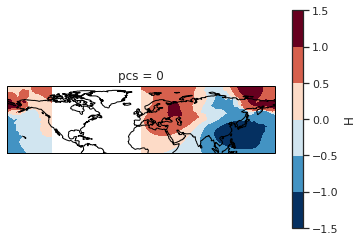

In [43]:
ax = plt.axes(projection=ccrs.PlateCarree())
cor.H.isel(level=0).plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

In [55]:
# Panel Plot of Correlation with EOF1 and EOF2

# Data for plotting extratropics
lons = ds_ar.lon.data
lats = ds_ar.lat.data
## stack results into single data array
data = np.vstack((cormaph250, cormapq250, cormapv250, cormapu250))
data2 = np.vstack((cormaph850, cormapq850, cormapv850, cormapu850))

## stack pval results into single data array
pvaldata = np.vstack((pvalh250, pvalq250, pvalv250, pvalu250))
pvaldata2 = np.vstack((pvalh850, pvalq850, pvalv850, pvalu850))

print(np.min(data), np.max(data))
print(np.min(pvaldata), np.max(pvaldata))

EOF_labels = ['EOF1']

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

nplots=8

# subtitles
eof_label = [ ]
pool = cycle(['1', '2'])
for k in range(nplots):
    neof = next(pool)
    eof_label.append("EOF{0}".format(neof))
    
var_label = ['H', 'H', 'Q', 'Q', 'V', 'V', 'U', 'U']    


-0.8019855310855776 0.8000753254837536
1.3529398003705742e-45 2.0


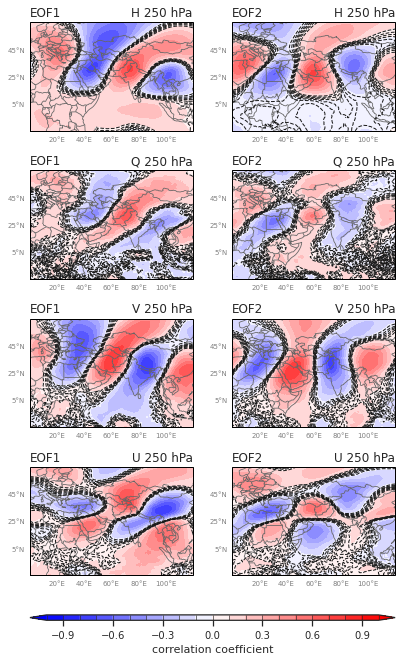

In [58]:
# Create figure
fig = plt.figure(figsize=(10,11))
filepath = path_to_figs + 'cors_huvq250'+ fname_id + '.png'
nrows = 4
ncols = 2
# sns.set_style('ticks')

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 
                111, 
                axes_class=axes_class,
                nrows_ncols=(nrows, ncols), 
                axes_pad = 0.55,
                cbar_location='bottom', 
                cbar_mode='single',
                cbar_pad=0.0, 
                cbar_size='2.5%',
                label_mode='')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Add contour fill plot for correlation maps
    clevs = np.arange(-1,1.1,0.1)
    cf = ax.contourf(lons, lats, data[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="bwr", extend='both')
    
    # Add contours for pval
    kw_clabels = {'fontsize': 11, 'inline': True, 'inline_spacing': 5, 'fmt': '%0.2f',
                  'rightside_up': True, 'use_clabeltext': True}
    clevs = np.arange(0., 2.25, 0.25)
    cs = ax.contour(lons, lats, pvaldata[k, :, :], levels=clevs, colors='k',
                        linewidths=1.0, linestyles='dashed', transform=datacrs)
    
    # subtitles
    ax.set_title(eof_label[k], loc='left', fontsize=12)
    ax.set_title(var_label[k]+' 250 hPa', loc='right', fontsize=12)
    
# single colorbar
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('correlation coefficient', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Display figure
plt.savefig(filepath, dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
# Create figure
fig = plt.figure(figsize=(10,11))
filepath = path_to_figs + 'cors_huvq850'+ fname_id + '.png'
nrows = 4
ncols = 2
# sns.set_style('ticks')

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 
                111, 
                axes_class=axes_class,
                nrows_ncols=(nrows, ncols), 
                axes_pad = 0.55,
                cbar_location='bottom', 
                cbar_mode='single',
                cbar_pad=0.0, 
                cbar_size='2.5%',
                label_mode='')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Add contour fill plot for correlation maps
    clevs = np.arange(-1,1.1,0.1)
    cf = ax.contourf(lons, lats, data2[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="bwr", extend='both')
    
    # subtitles
    ax.set_title(eof_label[k], loc='left', fontsize=12)
    ax.set_title(var_label[k]+' 850 hPa', loc='right', fontsize=12)
    
# single colorbar
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('correlation coefficient', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Display figure
plt.savefig(filepath, dpi=200, bbox_inches='tight')
plt.show()